In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Define functions

In [2]:
def generate_A(M, min_cells, max_cells):
    A_cols = []
    for m in range(M):
        n = np.random.randint(min_cells, max_cells)
        A_cols.append(np.ones(n))
    new_A_cols = []
    for r, row in enumerate(A_cols):
        if r == 0:
            zf = len(np.hstack(A_cols)) - len(row)
            new_A_cols.append(np.hstack([row, np.zeros(zf)]))
        else:
            zi = int(np.sum(new_A_cols))
            zf = len(np.hstack(A_cols)) - len(row) - zi
            new_A_cols.append(np.hstack([np.zeros(zi), row, np.zeros(zf)]))
    A = np.stack(new_A_cols)
    return A


def generate_C(A, probabilities):
    M, N = A.shape
    L = len(probabilities)
    C = np.zeros((M, L))
    for i in range(M):
        spot_indices = np.where(A[i] == 1)[0]
        cell_types = np.random.choice(L, size=len(spot_indices), p=probabilities)
        for j, cell_type in zip(spot_indices, cell_types):
            C[i, cell_type] += 1
    C[:, 0] += A.sum(axis=1) - C.sum(axis=1)
    return C


def generate_X(A, C):
    X = []
    for row_A, row_C in zip(A, C):
        row_X = np.copy(row_A)
        indices = np.where(row_A == 1)[0]
        row_X[indices] = np.repeat(np.arange(1, C.shape[1] + 1), row_C.astype(int))
        X.append(row_X)
    X_sparse = np.stack(X)
    X_sum = X_sparse.sum(axis=0)
    return X_sum, X_sparse


def generate_X_perm(X_sparse):
    X_sparse_perm = []
    for row_X in X_sparse:
        indices = np.where(row_X>0)[0]
        subrow_X = row_X[indices[0]:indices[-1]+1]
        np.random.shuffle(subrow_X)
        row_X[indices[0]:indices[-1]+1]=subrow_X
        X_sparse_perm.append(row_X)
    X_sparse_perm = np.stack(X_sparse_perm)
    X_perm = X_sparse_perm.sum(axis=0)
    return X_perm, X_sparse_perm


def generate_B(X, K, feature_overlap=1.0):
    N = len(X)
    B = np.zeros((N, K))
    for label in np.unique(X):
        for k in range(K):
            indices = np.where(X == label)[0]
            B[indices, k] = np.random.normal(label, feature_overlap, len(indices))
    scaler = StandardScaler()
    B = scaler.fit_transform(B)
    return B

In [3]:
def plot_bags_in_grid(matrix_X, grid_size, seed, figsize):
    np.random.seed(seed)
    num_bags, num_instances = matrix_X.shape
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    for bag_index in range(num_bags):
        bag_radius = 1 
        grid_row = bag_index // grid_size[1]
        grid_col = bag_index % grid_size[1]
        bag_center = (grid_col * 3, -grid_row * 3) 
        ax.add_patch(plt.Circle(bag_center, bag_radius, color='gray', alpha=0.3))
        instances_indices = np.where(matrix_X[bag_index] != 0)[0]
        if len(instances_indices) > 0:
            for instance_index in instances_indices:
                class_shapes = ['o', '^', 's', 'D']  
                class_colors = ['red', 'green', 'purple', 'blue'] 
                label = int(matrix_X[bag_index, instance_index]) % len(class_shapes)
                theta = 2 * np.pi * np.random.rand(1)
                radius = bag_radius * np.sqrt(np.random.rand(1))
                x = bag_center[0] + radius * np.cos(theta)/1.25
                y = bag_center[1] + radius * np.sin(theta)/1.25
                ax.scatter(x, y, marker=class_shapes[label], color=class_colors[label], s=75, edgecolors='black', alpha=.7)
    ax.set_aspect('equal', adjustable='datalim')
    return ax

# Simulate data

In [4]:
min_n,max_n = 2,9       # range of cells per spot
M = 10                  # number of spots
K = 15                  # number of features per cell
feature_overlap = 1.5   # feature overlap

In [5]:
# Three layer formation with proportion of cell types per layer
A_1 = generate_A(M, min_n,max_n)
C_1 = generate_C(A_1, np.array([0.6, 0.1, 0.2, 0.1]))

A_2 = generate_A(M, min_n,max_n)
C_2 = generate_C(A_2, np.array([0.1, 0.7, 0.1, 0.1]))

A_3 = generate_A(M, min_n,max_n)
C_3 = generate_C(A_3, np.array([0.3, 0.1, 0.5, 0.1]))

A = np.vstack([np.hstack([A_1,np.zeros(A_2.shape),np.zeros(A_3.shape)]),
           np.hstack([np.zeros(A_1.shape),A_2,np.zeros(A_3.shape)]),
           np.hstack([np.zeros(A_1.shape),np.zeros(A_2.shape),A_3])])
C = np.vstack([C_1,C_2,C_3])

# Generate cell types
X, X_sparse = generate_X(A,C)

# Generate permuted cell types
X_perm, X_sparse_perm = generate_X_perm(X_sparse.copy())

# Generate features per cell
B = generate_B(X, K, feature_overlap)

# Plot data

/tmp/ipykernel_632577/2244824644.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


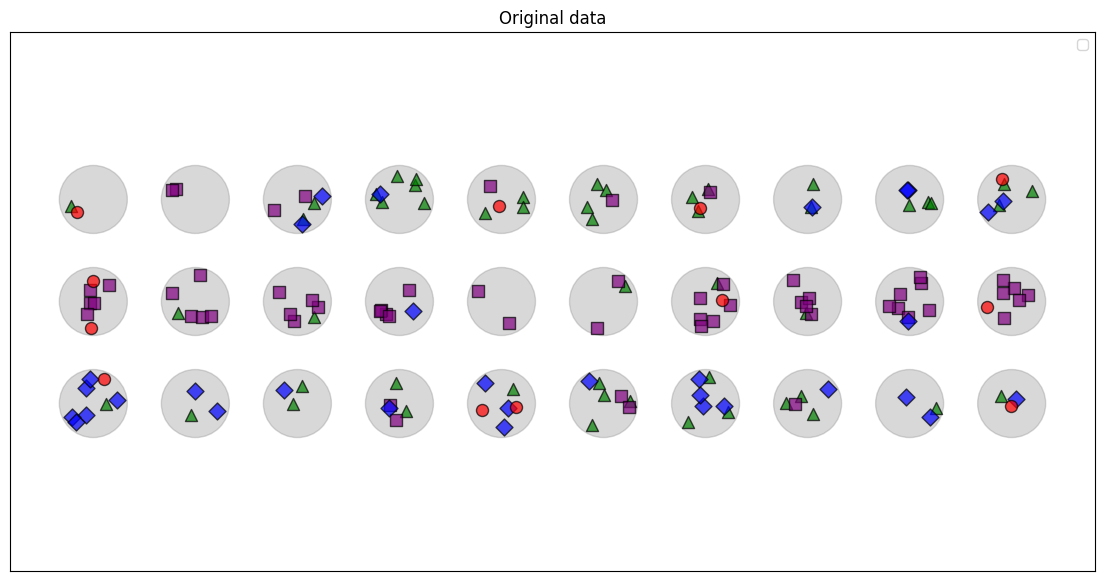

In [6]:
grid_size = (3, M)  # Rows and columns in the grid
ax = plot_bags_in_grid(X_sparse, grid_size, 0, (14,7))
ax.set_title('Original data')
ax.set_xticks([])
ax.set_yticks([])
ax.legend()

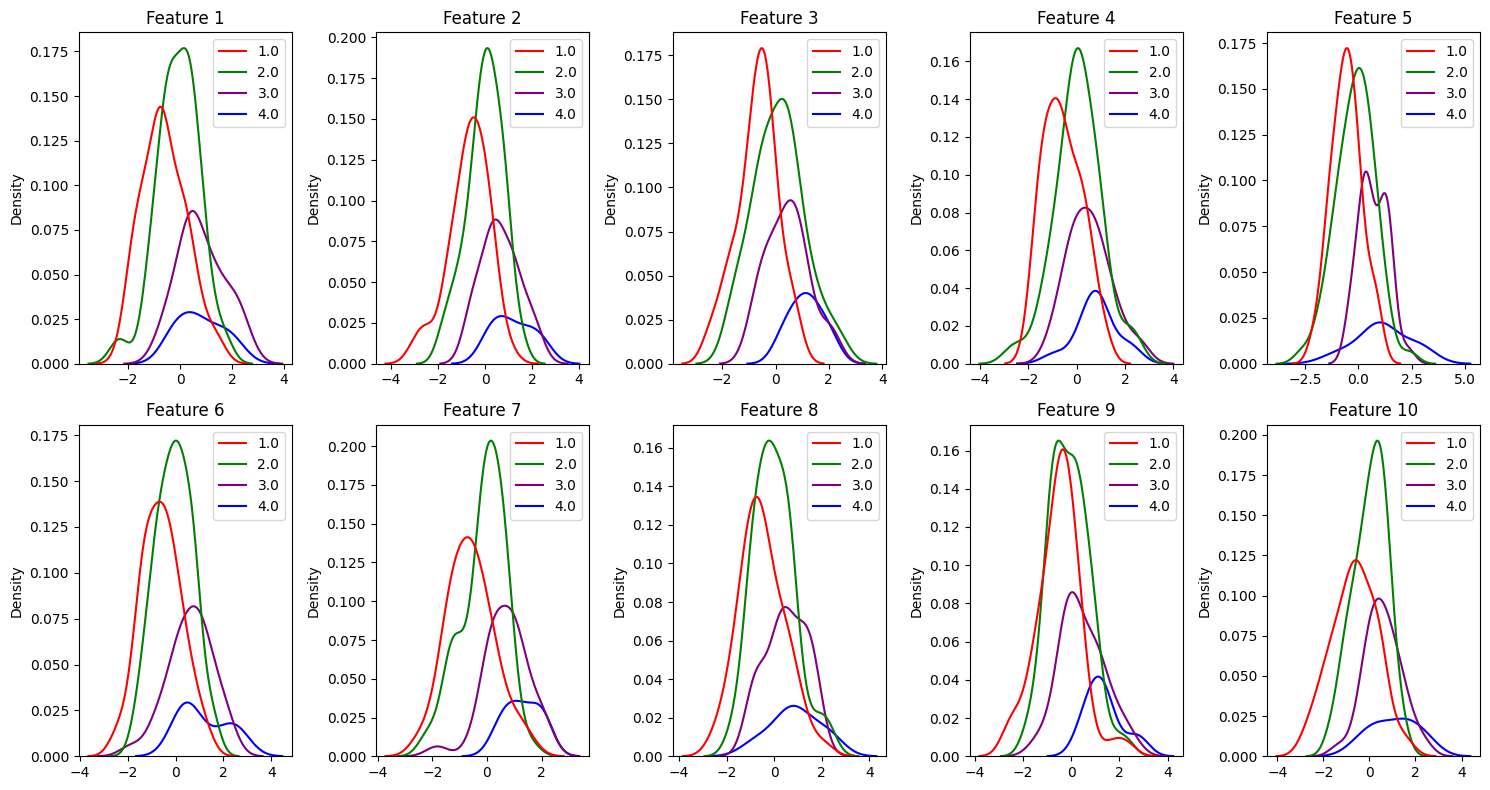

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()
for i in range(10):
    sns.kdeplot(x=B[:, i], hue=X, ax=axes[i], palette=['red','green', 'purple', 'blue'])
    axes[i].set_title(f'Feature {i+1}')
plt.tight_layout()
plt.show()

# Run method

In [8]:
from celltype_permutation import hierarchical_permutations

X_global = hierarchical_permutations(A, X_perm, B)

--------------------------------------------------------------
M_spot	 Perm_1	 	 Perm_2	 CHI
--------------------------------------------------------------
0 	 2 		 2 	 -inf
1 	 1 		 1 	 -inf
2 	 90 		 2 	 1.6705298891355063
3 	 7 		 1 	 1.601723424068792
4 	 20 		 2 	 2.2736886268170027
5 	 5 		 1 	 1.7029125540135053
6 	 20 		 2 	 1.7649902294385449
7 	 3 		 1 	 4.597123569367348
8 	 10 		 1 	 1.7420832216716888
9 	 60 		 1 	 3.4769845781172566
10 	 21 		 1 	 3.1189667502488985
11 	 6 		 1 	 1.6530149384702317
12 	 6 		 1 	 1.8268323806098388
13 	 6 		 1 	 1.7055910241217038
14 	 1 		 1 	 -inf
15 	 3 		 1 	 2.114586909741984
16 	 56 		 2 	 3.6232001010404327
17 	 6 		 1 	 1.1960165903193973
18 	 8 		 1 	 1.584048444580587
19 	 7 		 1 	 1.5822503002800024
20 	 56 		 2 	 1.7134055695642687
21 	 3 		 1 	 3.716849534410019
22 	 3 		 1 	 1.9106862918379277
23 	 30 		 2 	 1.785897998581314
24 	 60 		 1 	 2.9793441837535317
25 	 105 		 1 	 2.306220707793942
26 	 35 		 1 	 4.860150285754454


Global Permutations: 100%|██████████| 1536/1536 [00:01<00:00, 1338.02it/s]

Maximum Score: 10.446141559388558
Total time: 1.5695862770080566


## Evaluate results

In [9]:
from sklearn.metrics import classification_report

In [10]:
print('BEFORE')
print(classification_report(X, X_perm))

BEFORE
              precision    recall  f1-score   support

         1.0       0.63      0.63      0.63        51
         2.0       0.77      0.77      0.77        60
         3.0       0.53      0.53      0.53        32
         4.0       0.08      0.08      0.08        12

    accuracy                           0.62       155
   macro avg       0.50      0.50      0.50       155
weighted avg       0.62      0.62      0.62       155



In [11]:
print('AFTER')
print(classification_report(X, X_global))

AFTER
              precision    recall  f1-score   support

         1.0       0.82      0.82      0.82        51
         2.0       0.85      0.85      0.85        60
         3.0       0.72      0.72      0.72        32
         4.0       0.75      0.75      0.75        12

    accuracy                           0.81       155
   macro avg       0.79      0.79      0.79       155
weighted avg       0.81      0.81      0.81       155

